In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

# Méthode de Debevec

https://github.com/vivianhylee/high-dynamic-range-image/blob/master/hdr.py

In [2]:
# valeurs minimales et maximales des pixels
z_min = 0. 
z_max = 255.

In [3]:
def w(z):#linear weight
    # z = valeur du pixel
    # equation (4) 
    # "to emphasize the smoothness and fitting terms toward the middle of the curve" (de l'article)
    
    res = 0
    if z <= (z_min + z_max) / 2:
        res = z - z_min
    else:
        res = z_max - z
        
    return res

In [4]:
def sampleIntensities(images, num_images):# récupère l'intensité de chaque image à partir de l'exposition
    # images = liste des images; num_images = nombre d'images
    """Randomly sample pixel intensities from the exposure stack.
    """
    num_intensities = z_max - z_min + 1
    intensity_values = np.zeros((int(num_intensities), num_images), dtype=np.uint8)

    # récupère l'image du mileu, celle dont l'exposition est moyenne, pour l'utiliser comme base 
    mid_img = images[num_images // 2]

    for i in range(int(z_min), int(z_max) + 1):
        rows, cols = np.where(mid_img == i)
        if len(rows) != 0:
            idx = random.randrange(len(rows))
            for j in range(num_images):
                intensity_values[i, j] = images[j][rows[idx], cols[idx]]
    return intensity_values


In [5]:
def computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, weighting_function, num_images):
    #log_exposures = tableau des temps d'exposition; weighting_function = w(z)
    #smoothing_lambda = l = constant qui determine le degrès de smoothness
    #intensity_samples = Z = valeur de pixel
    #num_images = nombre d'images
    
    #CODE MATLAB

    n = 255  # difference entre la valeur de pixel minimale et la valeur maximale
    num_samples = intensity_samples.shape[0]

    A = np.zeros((num_images * num_samples + n, num_samples + n + 1), dtype=np.float64)
    b = np.zeros((A.shape[0], 1), dtype=np.float64)

    # Include the data−fitting equations
    k = 0
    for i in range(num_samples):
        for j in range(num_images):
            wij = weighting_function(intensity_samples[i, j])
            A[k, intensity_samples[i, j]] = wij
            A[k, (n + 1) + i] = -wij
            b[k, 0] = wij * log_exposures[j]
            k += 1 
            
    # Fix the curve by setting its middle value to 0
    A[k, n // 2] = 1

    # Include the smoothness equations
    for i in range(int(z_min) + 1, int(z_max)):
        w_k = weighting_function(i)
        A[k, i - 1] = w_k * smoothing_lambda
        A[k, i    ] = -2 * w_k * smoothing_lambda
        A[k, i + 1] = w_k * smoothing_lambda
        k += 1
        
    # Solve the system
    inv_A = np.linalg.pinv(A)
    x = np.dot(inv_A, b)

    g = x[0: n + 1]
    return g[:, 0]

In [6]:
def computeRadianceMap(images, log_exposure_times, response_curve, weighting_function, num_images):
    # images = liste des images; log_exposure_times = tableau des temps d'exposition
    # response_curve = l; weighting_function = w; num_images = nombre d'images
    # equation (6) 
    # "For robustness, and to recover high dynamic range radiance values" (de l'article)

    img_shape = images[0].shape # = taille de l'image (x,y)
    img_rad_map = np.zeros(img_shape, dtype=np.float64)

    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            # retour de la méthode donnée dans l'article pour le pixel i,j de l'image k
            g = np.array([response_curve[images[k][i, j]] for k in range(num_images)])
            
            # retour de la méthode w() pour le pixel i,j de l'image k
            w = np.array([weighting_function(images[k][i, j]) for k in range(num_images)])
            
            SumW = np.sum(w)#représente le dénominateur de l'équation (6)
            
            # equation (6)
            img_rad_map[i, j] = np.sum(w * (g - log_exposure_times) / SumW) # log_exposure_times = ln(Δtj) dans l'article
            
    return img_rad_map

In [7]:
def globalToneMapping(image, gamma):
    """Global tone mapping using gamma correction
    """
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected

In [8]:
def intensityAdjustment(image, template):
    #image = liste d'images, template = l'image du milieu
    """Tune image intensity based on template
    """
    m, n, channel = image.shape
    output = np.zeros((m, n, channel))
    for ch in range(channel):
        image_avg, template_avg = np.average(image[:, :, ch]), np.average(template[:, :, ch])
        output[..., ch] = image[..., ch] * (template_avg / image_avg)

    return output

In [9]:
def computeHDR(images, log_exposure_times, l=100., gamma=0.6):# créer l'image HDR
    #l = smoothing_lambda; images = liste d'images
    #log_exposure_times = tableau des temps d'exposition

    # valeurs minimales et maximales des pixels
    z_min = 0. 
    z_max = 255.
    num_images = len(images)
    
    num_channels = images[0].shape[2] # = 3
    hdr_image = np.zeros(images[0].shape, dtype=np.float64)

    for channel in range(num_channels):
        # récupère la valeur de chaque channel de chaque pixel pour toutes les images
        layer_stack = [img[:, :, channel] for img in images]

        # récupère l'intensité de chaque image à partir de l'exposition
        intensity_samples = sampleIntensities(layer_stack, num_images)

        # méthode donnée dans l'article
        response_curve = computeResponseCurve(intensity_samples, log_exposure_times, l, w, num_images) 

        # équation (6) dans l'article
        img_rad_map = computeRadianceMap(layer_stack, log_exposure_times, response_curve, w, num_images)

        # normalise l'image obtenu entre 0 et 255
        hdr_image[..., channel] = cv2.normalize(img_rad_map, dst=img_rad_map, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Global tone mapping
    image_mapped = globalToneMapping(hdr_image, gamma)
    
    # Adjust image intensity based on the middle image from image stack
#     template = images[len(images)//2]
#     image_tuned = intensityAdjustment(image_mapped, template)
    
    # Output image
    output = cv2.normalize(image_mapped, dst=image_mapped, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)  
    
    return output.astype(np.uint8)

# Méthode de Debevec implémentée par OpenCV
https://docs.opencv.org/3.4/d3/db7/tutorial_hdr_imaging.html

In [10]:
import os

def loadExposureSeq(path):
    images = []
    times = []
    with open(os.path.join(path, 'list.txt')) as f:
        content = f.readlines()
    for line in content:
        tokens = line.split()
        images.append(cv2.imread(os.path.join(path, tokens[0])))
        times.append(1 / float(tokens[1]))
    return images, np.asarray(times, dtype=np.float32)

In [11]:
def cv2Debevec(pathSrc, pathFusion, pathLDR, pathHDR):
    fig=plt.figure(figsize=(15, 8))

    images, times = loadExposureSeq(pathSrc)

    calibrate = cv2.createCalibrateDebevec()
    response = calibrate.process(images, times)

    merge_debevec = cv2.createMergeDebevec()
    hdr = merge_debevec.process(images, times, response)

    tonemap = cv2.createTonemap(2.2)
    ldr = tonemap.process(hdr)

    merge_mertens = cv2.createMergeMertens()
    fusion = merge_mertens.process(images)

    fig.add_subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB))
    cv2.imwrite(pathFusion+'.png', fusion * 255)

    fig.add_subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(ldr, cv2.COLOR_BGR2RGB))
    cv2.imwrite(pathLDR+'.png', ldr * 255)

    fig.add_subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(hdr, cv2.COLOR_BGR2RGB))
    cv2.imwrite(pathHDR+'.hdr', hdr)

    plt.show()

# Premier test
Images fournises avec le code pour utiliser la méthode de Debvec d'OpenCV :
https://github.com/opencv/opencv_extra/tree/3.4/testdata/cv/hdr/exposures

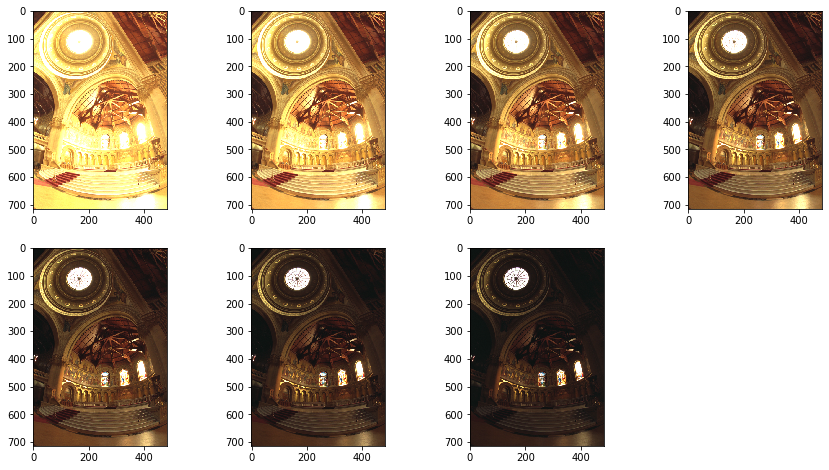

In [12]:
fig=plt.figure(figsize=(15, 8))

imagesMem = []
for i in range(0,7):
    img = cv2.imread('./memorial/memorial0'+str(i)+'.png')
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagesMem.append(img)
    fig.add_subplot(2, 4, i+1)
    plt.imshow(img)
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


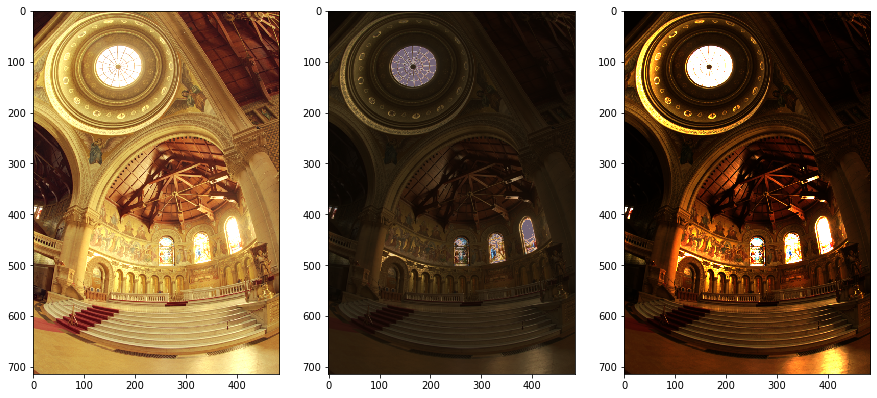

In [13]:
cv2Debevec('./memorial/', './memorial/resultats/OpenCV_fusion', './memorial/resultats/OpenCV_ldr', './memorial/resultats/OpenCV_hdr')

C:\Users\UTILISATEUR\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


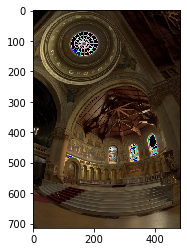

True

In [14]:
output = computeHDR(imagesMem,[3,2,1,0,-1,-2,-3])
plt.imshow(output)
plt.show()
res = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
cv2.imwrite('./memorial/resultats/Debevec_res.png',res)

# Deuxième test
Images alignées données

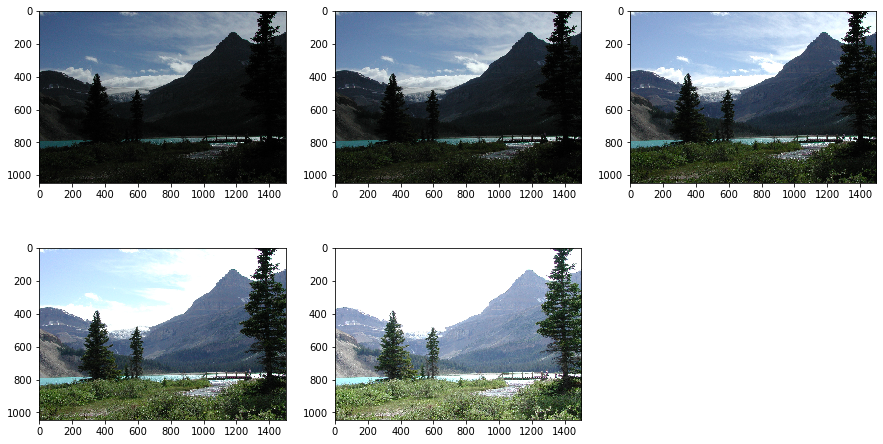

In [15]:
fig=plt.figure(figsize=(15, 8))

imagesA = []
for i in range(0,5):
    img = cv2.imread('./aligned/aligned_'+str(i)+'.bmp')
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagesA.append(img)
    fig.add_subplot(2, 3, i+1)
    plt.imshow(img)
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


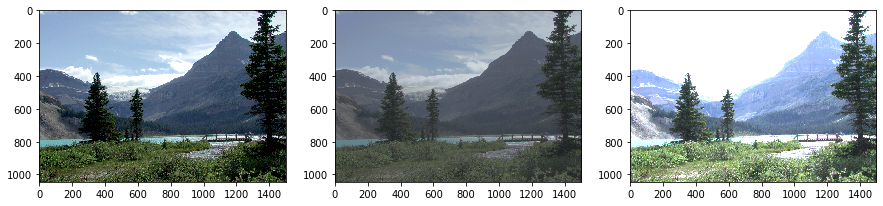

In [16]:
cv2Debevec('./aligned/', './aligned/resultats/OpenCV_fusion', './aligned/resultats/OpenCV_ldr', './aligned/resultats/OpenCV_hdr')

C:\Users\UTILISATEUR\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


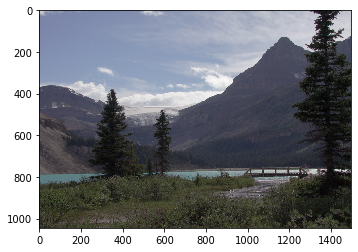

True

In [17]:
outputA = computeHDR(imagesA,[-2,-1,0,1,2])
plt.imshow(outputA)
plt.show()
res = cv2.cvtColor(outputA, cv2.COLOR_BGR2RGB)
cv2.imwrite('./aligned/resultats/Debevec_res.bmp',res)

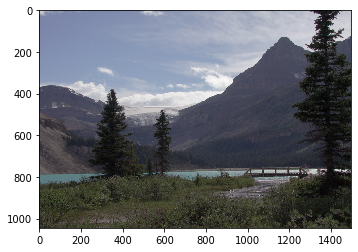

In [18]:
#utilisation de l'image déjà crée auparavant 
res = cv2.imread('./aligned/resultats/Debevec_res.bmp')
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)
plt.show()

# Troisième test
Images non alignées données

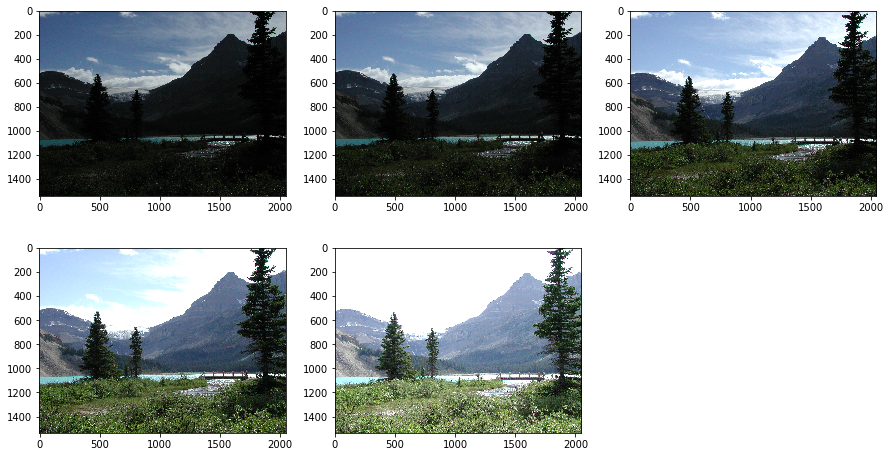

In [19]:
fig=plt.figure(figsize=(15, 8))

imagesNA = []
for i in range(0,5):
    img = cv2.imread('./NonAligned/'+str(i)+'.bmp')
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagesNA.append(img)
    fig.add_subplot(2, 3, i+1)
    plt.imshow(img)
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


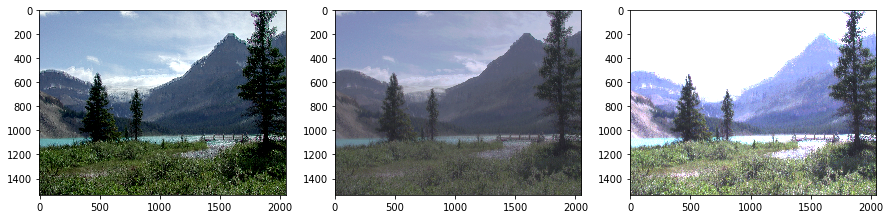

In [20]:
cv2Debevec('./NonAligned/', './NonAligned/resultats/OpenCV_fusion', './NonAligned/resultats/OpenCV_ldr', './NonAligned/resultats/OpenCV_hdr')

C:\Users\UTILISATEUR\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


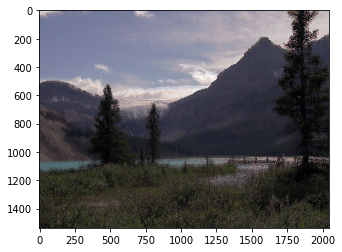

True

In [21]:
outputNA = computeHDR(imagesNA,[-2,-1,0,1,2])
plt.imshow(outputNA)
plt.show()
res = cv2.cvtColor(outputNA, cv2.COLOR_BGR2RGB)
cv2.imwrite('./NonAligned/resultats/Debevec_res.bmp',res)

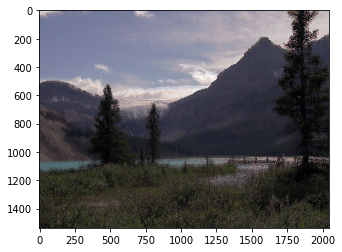

In [22]:
#utilisation de l'image déjà crée auparavant
res = cv2.imread('./NonAligned/resultats/Debevec_res.bmp')
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)
plt.show()

# Quatrième test
Images issues d'un jeu

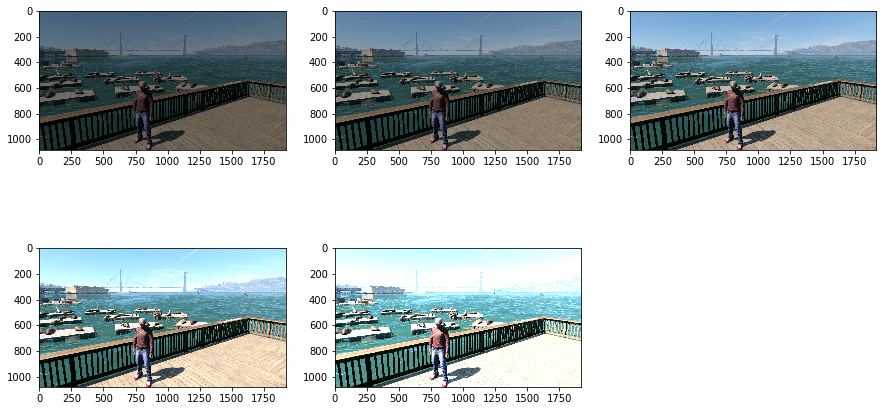

In [23]:
fig=plt.figure(figsize=(15, 8))

imagesJeu = []
for i in range(2,7):
    img = cv2.imread('./Pier_39/img'+str(i)+'.png')
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagesJeu.append(img)
    fig.add_subplot(2, 3, (i-2)+1)
    plt.imshow(img)
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


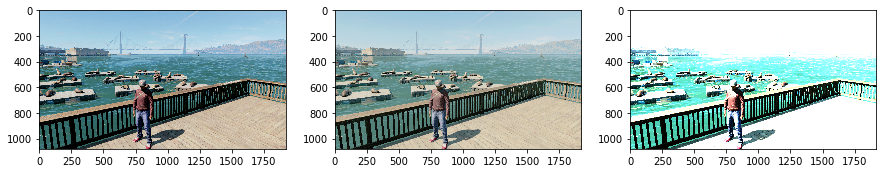

In [24]:
cv2Debevec('./Pier_39/', './Pier_39/resultats/OpenCV_fusion', './Pier_39/resultats/OpenCV_ldr', './Pier_39/resultats/OpenCV_hdr')

C:\Users\UTILISATEUR\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


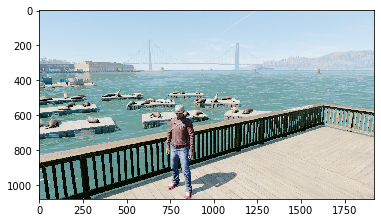

True

In [25]:
outputJeu = computeHDR(imagesJeu,[-2,-1,0,1,2])
#image HDR générée
plt.imshow(outputJeu)
plt.show()
res = cv2.cvtColor(outputJeu, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Pier_39/resultats/Debevec_res.png',res)

# Cinquième test
Images issues d'un jeu

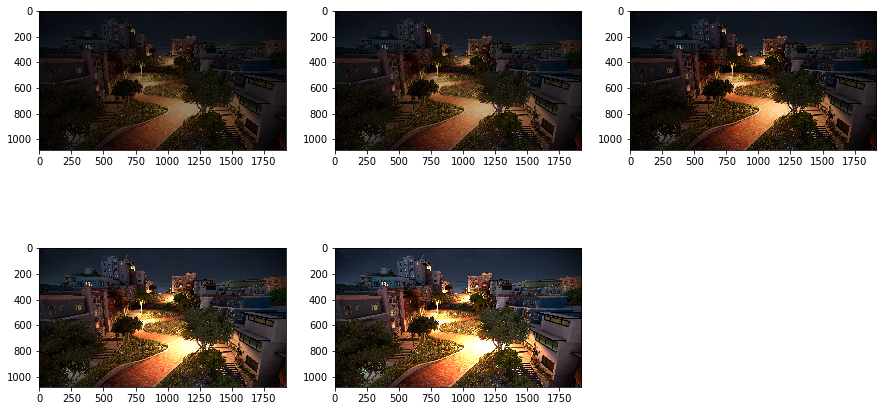

In [26]:
fig=plt.figure(figsize=(15, 8))

imagesJeu2 = []
for i in range(2,7):
    img = cv2.imread('./Lombart_Street/img'+str(i)+'.png')
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagesJeu2.append(img)
    fig.add_subplot(2, 3, (i-2)+1)
    plt.imshow(img)
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


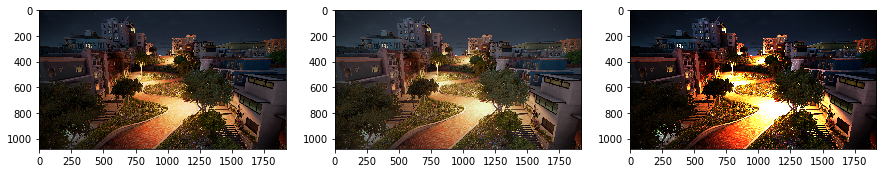

In [27]:
cv2Debevec('./Lombart_Street/', './Lombart_Street/resultats/OpenCV_fusion', './Lombart_Street/resultats/OpenCV_ldr', './Lombart_Street/resultats/OpenCV_hdr')

C:\Users\UTILISATEUR\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


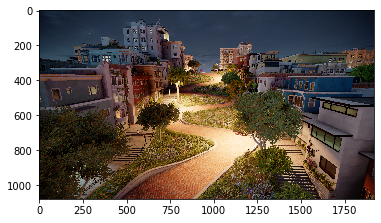

True

In [28]:
outputJeu2 = computeHDR(imagesJeu2,[-2,-1,0,1,2])
#image HDR générée
plt.imshow(outputJeu2)
plt.show()
res = cv2.cvtColor(outputJeu2, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Lombart_Street/resultats/Debevec_res.png',res)

# Comparaison avec une image HDR Nvidia 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


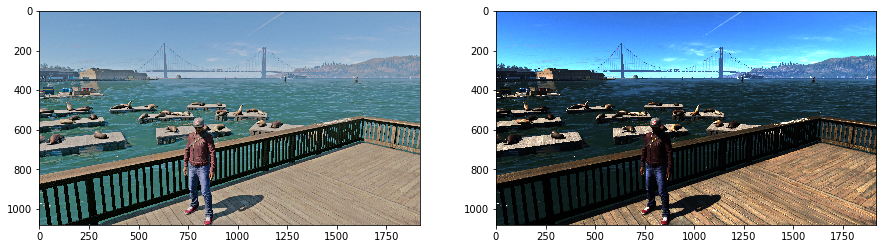

In [31]:
fig=plt.figure(figsize=(15, 8))

#image HDR générée par Nvidia (sans l'option "sauvegarder en HDR")
img = cv2.imread('./Pier_39/resultats/img1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 1)
plt.imshow(img)

#image HDR générée par Nvidia (avec l'option "sauvegarder en HDR")
img2 = cv2.imread('./Pier_39/resultats/img1.exr',  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


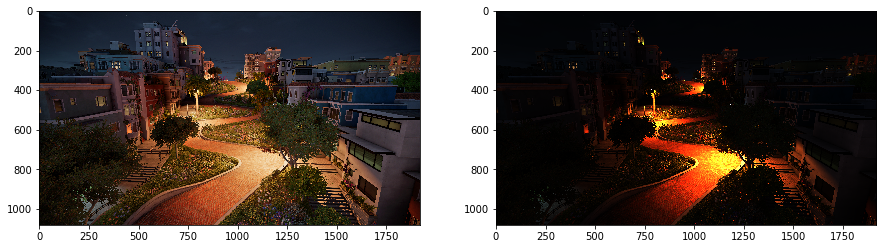

In [32]:
fig=plt.figure(figsize=(15, 8))

#image HDR générée par Nvidia (sans l'option "sauvegarder en HDR")
img = cv2.imread('./Lombart_Street/resultats/img1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 1)
plt.imshow(img)

#image HDR générée par Nvidia (avec l'option "sauvegarder en HDR")
img2 = cv2.imread('./Lombart_Street/resultats/img1.exr',  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)

plt.show()